<a href="https://colab.research.google.com/github/tomonari-masada/course2023-stats2/blob/main/03_NumPyro_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NumPyro入門 (2)
* 今回は、NumPyroの以下のチュートリアルを使う。
 * https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html

## 準備

In [1]:
!pip install arviz
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 16.2 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import random
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

import arviz as az

%config InlineBackend.figure_format = 'retina'

plt.style.use("bmh")
rng_key = random.PRNGKey(0)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

## NumPyroによるMCMC

### MCMC（マルコフ連鎖モンテカルロ）とは
* ベイズ的なモデリングにおいて、事後分布を知ろうとする方法の一つ。
 * もう一つの方法に、変分推論(variational inference)がある。
* MCMCは、事後分布からのサンプルを通して、事後分布そのものを知ろうとする方法。
* モデルが複雑になるほど、事後分布$p(\theta|X)$からのサンプリングは、難しくなっていく。
 * 比較的シンプルなモデルについては、うまいサンプリング手法を構成できる（例：LDAのcollapsed Gibbs sampling）。
* この授業では、MCMCの使い方を実践的に説明する。細かい理屈はあまり説明しない。
 * MCMCの解説としては https://arxiv.org/abs/1701.02434 などを参照のこと。

## 例題： The Spurious Waffles
* このデータセットについては、下のスライドを参照のこと。
 * https://speakerdeck.com/rmcelreath/l05-statistical-rethinking-winter-2019


* USの各州でのワッフル・ハウスというレストランの店舗数と、離婚率とに、正の相関がある？
* もちろんこれは、擬似連関(spurious association)。
 * https://www.tylervigen.com/spurious-correlations
 * 実際には、ワッフル・ハウスの店舗数に影響を与える他の要因と、離婚率との間に、相関がある。
 * なお、associationとcorrelationという言葉はあまり区別せず使われる。 
 * だが、correlationの方を特にlinearな連関に限定した意味で使うことがある。
* ここでは、擬似連関の分析には深入りしない。
* ベイズ回帰をNumPyroでどのように実装するかを説明するために、このデータセットを使う。

In [3]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


* ペアプロットで主要な変数どうしの関係を可視化する。

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


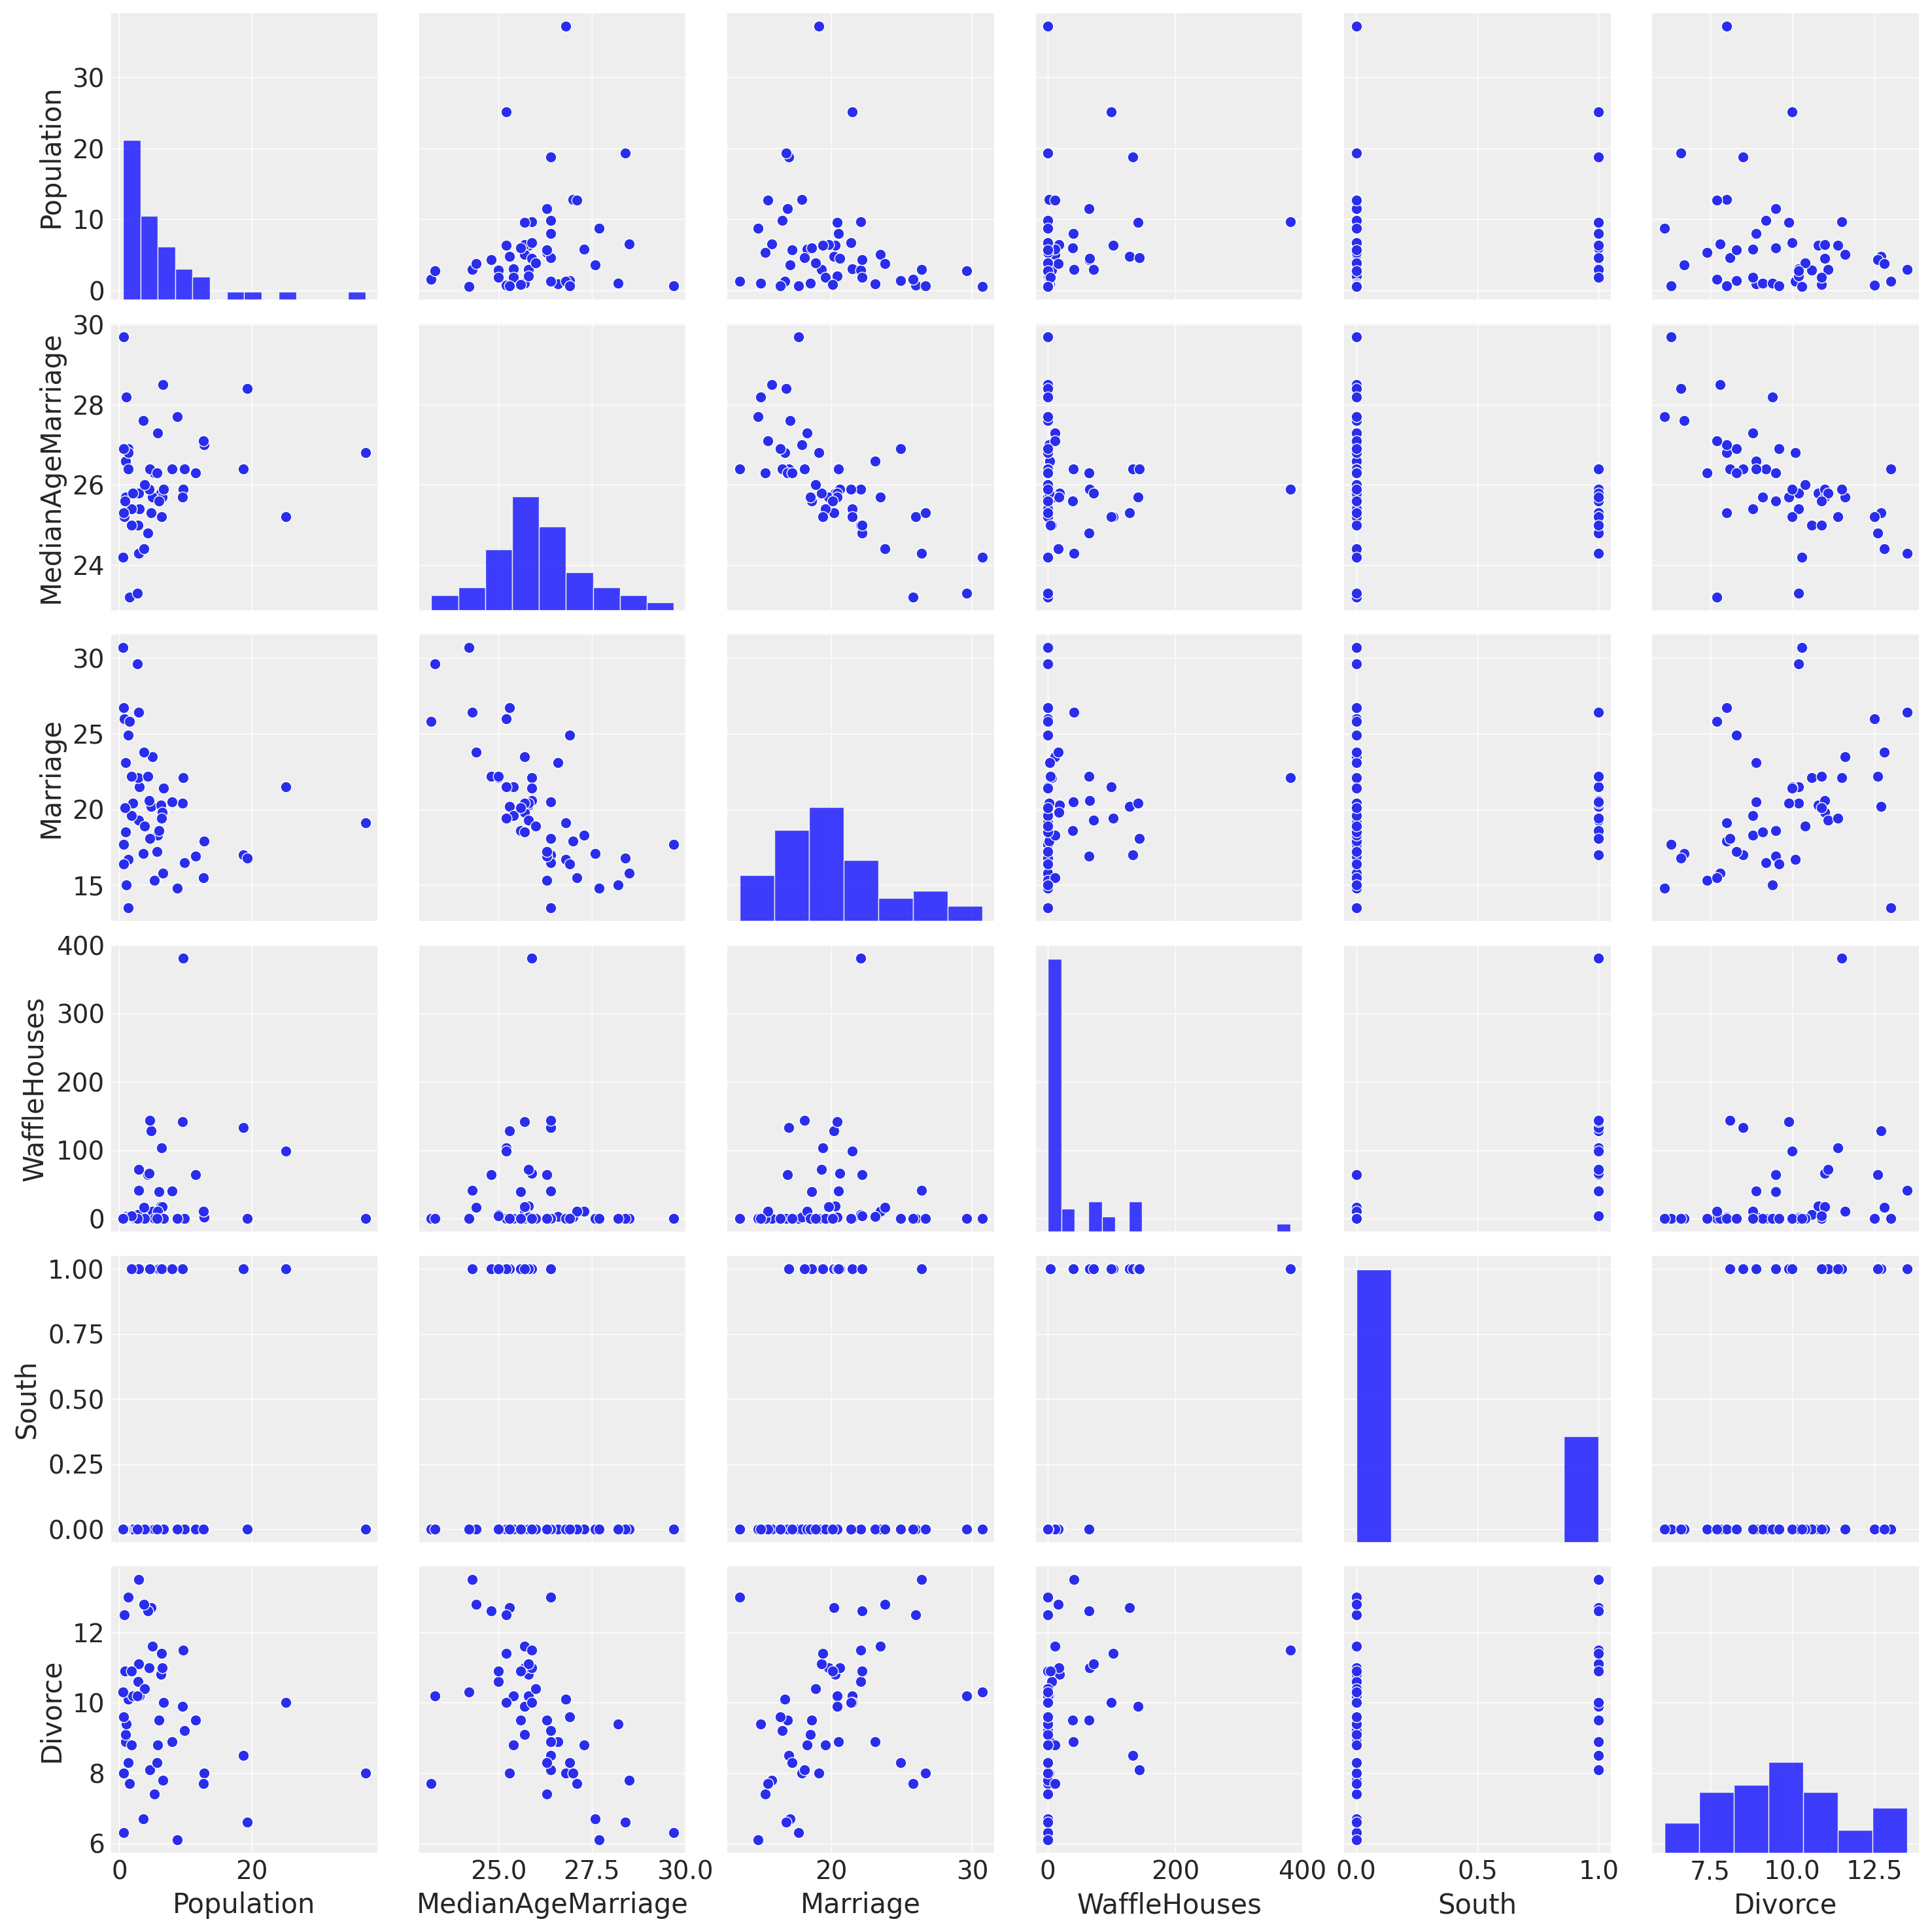

In [4]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl");

* ペアプロットから得られる観察
 * 離婚率と婚姻率の間には連関がありそう。
 * 離婚率と婚姻年齢の中央値の間にも連関がありそう。

* 問題の、離婚率とWaffle Houseの店舗数との連関を、seabornの`regplot`で可視化してみる。
 * この擬似連関ついては、下記の教科書の5,6章に議論があるらしい。
 * McElreath, R. (2016). [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/): A Bayesian Course with Examples in R and Stan CRC Press.

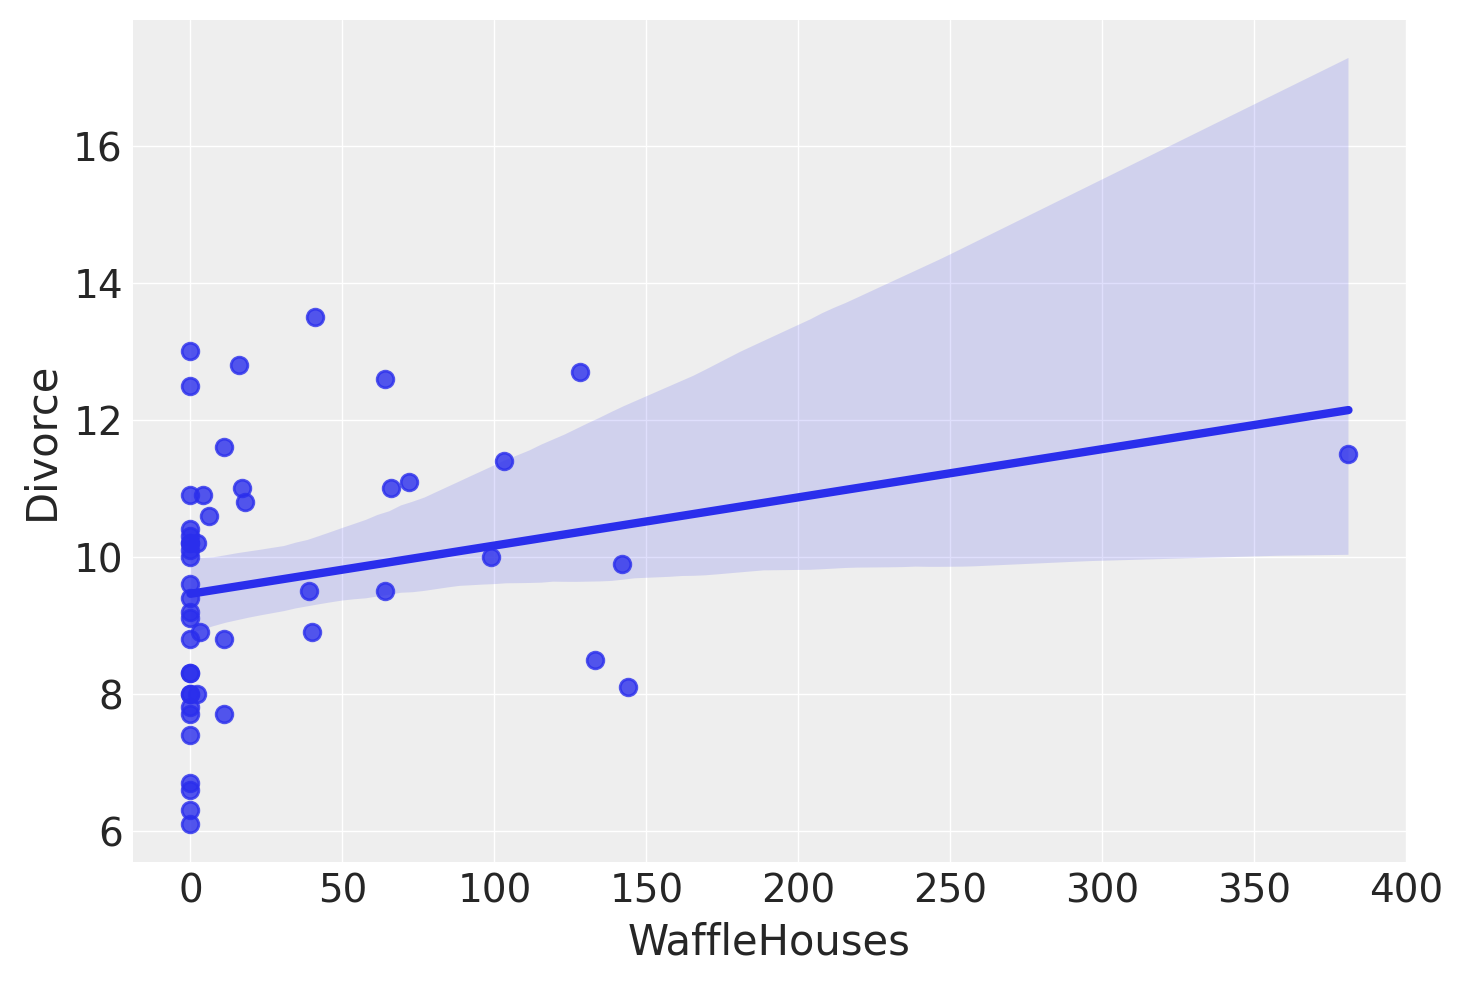

In [5]:
sns.regplot(x="WaffleHouses", y="Divorce", data=dset);

### データの標準化(standardization)
* これは、MCMCを使ったベイズ推論では、重要。
 * https://mc-stan.org/docs/stan-users-guide/standardizing-predictors-and-outputs.html

In [9]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

### 離婚率を予測するベイズ線形回帰モデル
* ここでは、離婚率を、以下の2つの説明変数(predictor)で予測することを考える。
 * 婚姻率
 * 婚姻年齢の中央値
* ベイズ回帰は、説明変数の係数がなんらかの事前分布に従うと仮定する点で、通常の回帰と異なる。
 * ここでは、係数は正規分布に従うと仮定する。


### モデルの実装
* NumPyroでは、モデルは関数として定義される。
* 目的変数はオプション引数としておく方が良い。
 * その理由は、じわじわ分かってくる。
* 今回、説明変数もオプション変数にしているのには、別の理由がある。
 * こうすると、一部の説明変数を使わないモデリングの際にも、同じ関数を使いまわせる。
* 係数が従う正規分布の標準偏差（NumPyroの言葉ではscale）は、この値でないといけないというわけではない。
 * 事前分布のパラメータ（ハイパーパラメータ）をどう設定するかは、常に問題になる。

In [6]:
def model(marriage=None, age=None, divorce=None):
  a = numpyro.sample("a", dist.Normal(0.0, 0.2))
  M, A = 0.0, 0.0
  if marriage is not None:
    bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
    M = bM * marriage
  if age is not None:
    bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
    A = bA * age
  sigma = numpyro.sample("sigma", dist.Exponential(1.0))
  mu = a + M + A
  numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

## モデル1: 婚姻率による予測
* 説明変数として婚姻率のみを使うモデリングをしてみる。
* 関数`model`では、説明変数をオプション引数にしたので、使用する変数にだけ値を設定すれば、使いまわしができる。

### MCMCの実行

* まず、擬似乱数のキーをsplitする。
 * これは、乱数に関してJAXでは独特の考え方をするため、必要になる。

In [7]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

* そして、NUTSサンプラを実行する。

* NUTS (No-U-Turn-Sampler) は、よく使われるサンプラー。
* HMCの改良版。詳細は割愛するが、おおよその説明は後ほど。
 * https://mc-stan.org/docs/reference-manual/hmc.html
 * https://arxiv.org/abs/1111.4246

In [11]:
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=2)
mcmc.run(
    rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)

<ipython-input-11-a226771a27c0>:3: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=2)
sample: 100%|██████████| 3000/3000 [00:01<00:00, 2465.45it/s, 3 steps of size 8.24e-01. acc. prob=0.91]


* chainとは、サンプルの一つの系列のこと。デフォルトではchainは一つだけ。
* MCMCによるサンプリングでは、直前のサンプルを少し変化させることで、次のサンプルを求める。
 * 前回説明したとおり、この変化のさせ方が賢いので、ちゃんと事後分布からのサンプルになる。
* ということは、サンプルは、初期値から始まる一筋の系列をなしている。この系列をchainと呼ぶ。
* 複雑なモデルの場合は、複数のchainを走らせることが多い。
 * 複雑なモデルだと、事後分布からのサンプリングも複雑になる。
 * そのため、複数のchainを比較して、うまくサンプリングができているかをチェックしたりする。

* サンプルの統計量を見てみる。

In [12]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11     -0.00     -0.18      0.20   4048.88      1.00
        bM      0.35      0.13      0.35      0.14      0.56   3992.24      1.00
     sigma      0.95      0.10      0.94      0.79      1.10   3056.59      1.00

Number of divergences: 0


**注意** divergenceが0でなかったら、色々と考え直す必要がある。（後の回で説明します。）
 

* サンプルを取得する。

In [13]:
samples_1 = mcmc.get_samples()
samples_1

{'a': Array([-0.03270136, -0.01555257,  0.19082968, ...,  0.03405264,
        -0.04468998,  0.01318217], dtype=float32),
 'bM': Array([0.37924942, 0.565737  , 0.4571873 , ..., 0.43016157, 0.2772782 ,
        0.27049667], dtype=float32),
 'sigma': Array([0.9864175 , 0.9416708 , 1.0666015 , ..., 0.83225274, 0.87451404,
        0.9315047 ], dtype=float32)}

* サンプルはJAXの配列になっている。

In [14]:
type(samples_1['a'])

jaxlib.xla_extension.Array

* Numpyのndarrayに変換することもできる。

In [15]:
type(np.array(samples_1['a']))

numpy.ndarray

### サンプルの可視化

* ここではArviZ向けのデータへ変換する。
 * こうすると、ArviZの様々な機能が使えるようになる。

In [16]:
idata_1 = az.from_numpyro(mcmc)
idata_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

* 特定のchainだけ選ぶ方法は以下の通り。

In [17]:
idata_1.posterior["a"].sel(chain=0).shape

(2000,)

* 最初のchainの、最初の10個のサンプルだけ見てみる。

In [19]:
idata_1.posterior["a"].sel(chain=0)[:10]

<xarray.DataArray 'a' (draw: 10)>
array([-0.03270136, -0.01555257,  0.19082968,  0.22538602, -0.12556866,
        0.00421646,  0.02353526,  0.04452734, -0.03235999, -0.0436115 ],
      dtype=float32)
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

* chainの中身のデータ型はxarrayの配列。
 * NumPyの配列とは違う。

In [20]:
type(idata_1.posterior["a"])

xarray.core.dataarray.DataArray

* `.data`でndarrayへ変換できる。

In [21]:
type(idata_1.posterior["a"].data)

numpy.ndarray

* 事後分布からのサンプル全体をpandasのデータフレームに変換することもできる。

In [53]:
df_idata_1 = idata_1.posterior.to_dataframe()
df_idata_1.head()

a        bM     sigma
chain draw                              
0     0    -0.032701  0.379249  0.986417
      1    -0.015553  0.565737  0.941671
      2     0.190830  0.457187  1.066602
      3     0.225386  0.515716  1.123981
      4    -0.125569  0.371199  0.848458

* サンプルのヒストグラムを描くと、事後分布の大体の形が分かる。
* まずは、あえてArviZを使わずに、seabornでヒストグラムを描いてみる。

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


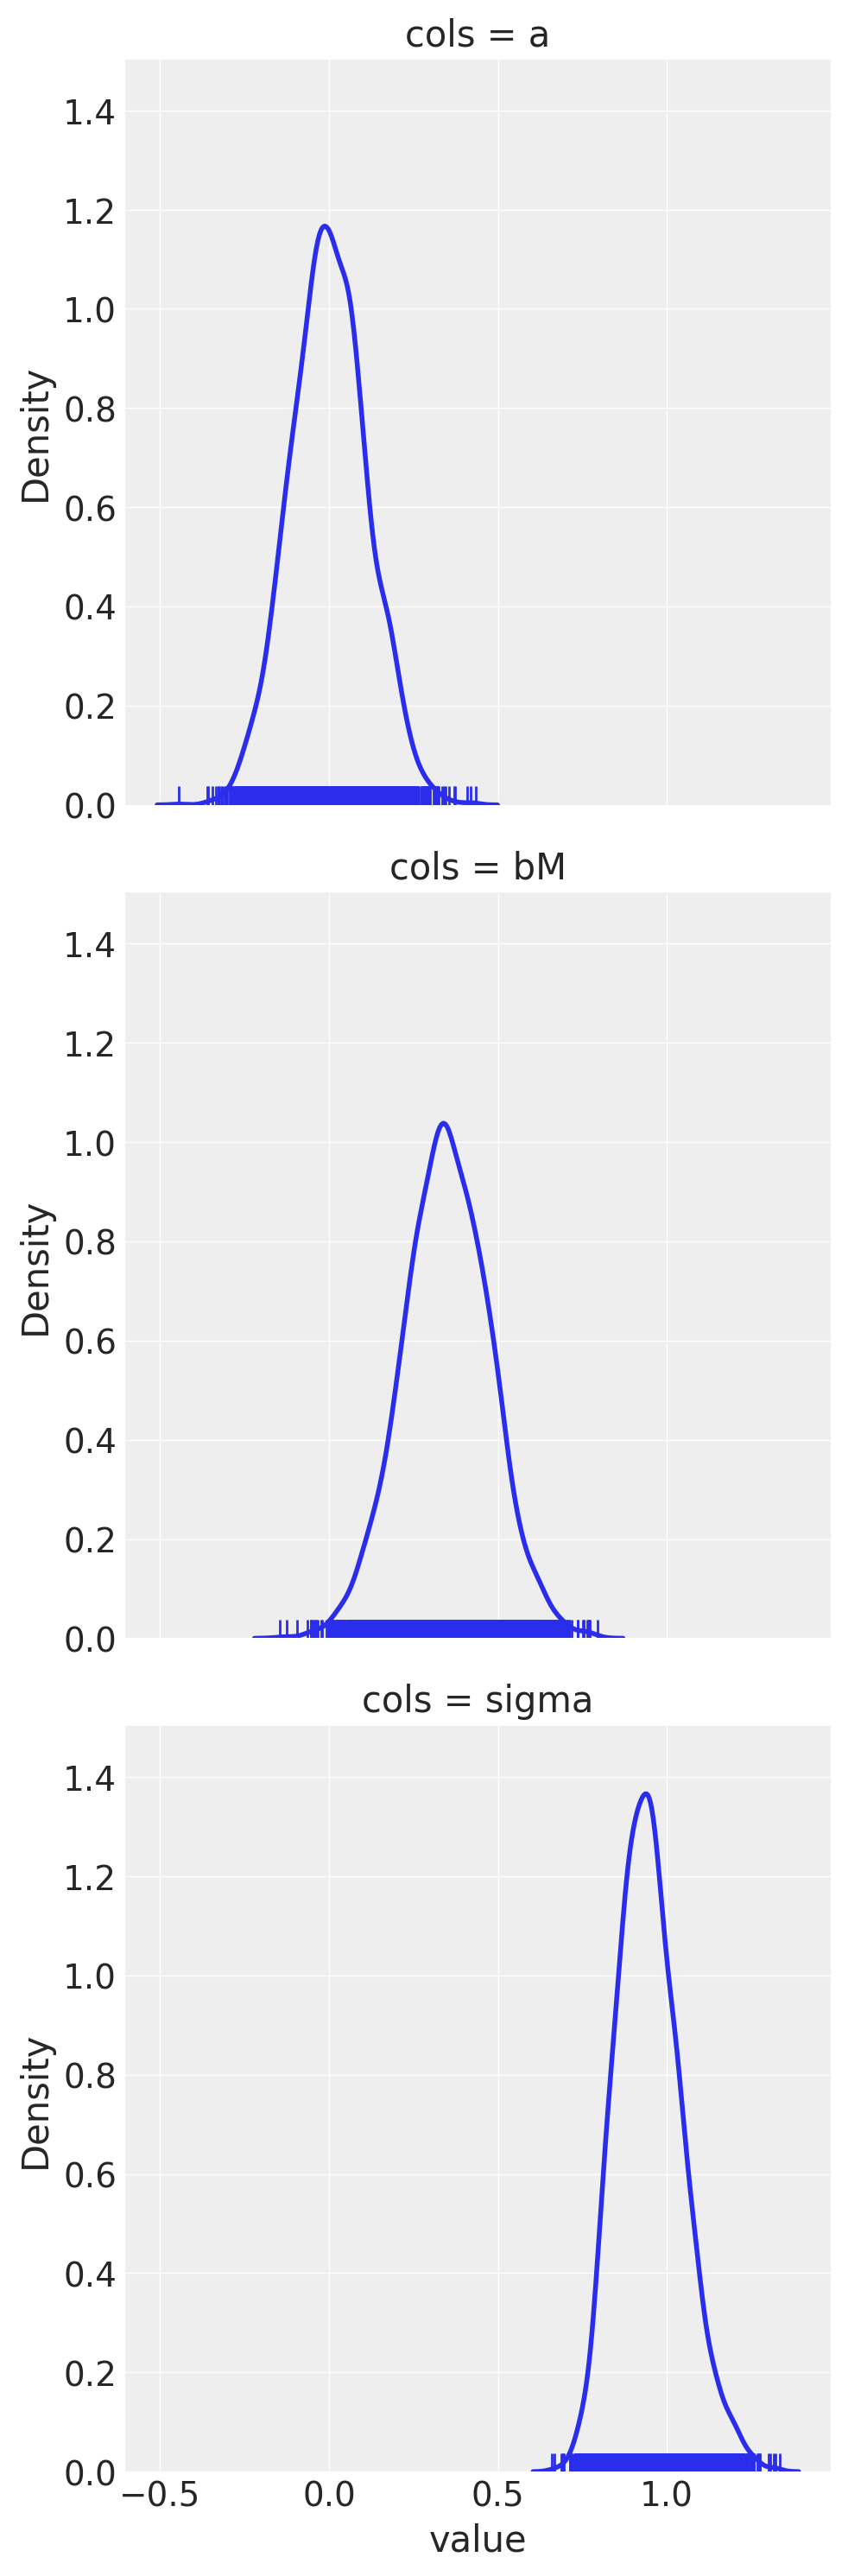

In [54]:
sns.displot(
    df_idata_1.melt(var_name="cols", value_name="value"),
    x="value", row="cols",
    kind="kde", rug=True
    );

* とはいえ、やはりArviZを使うことにする。

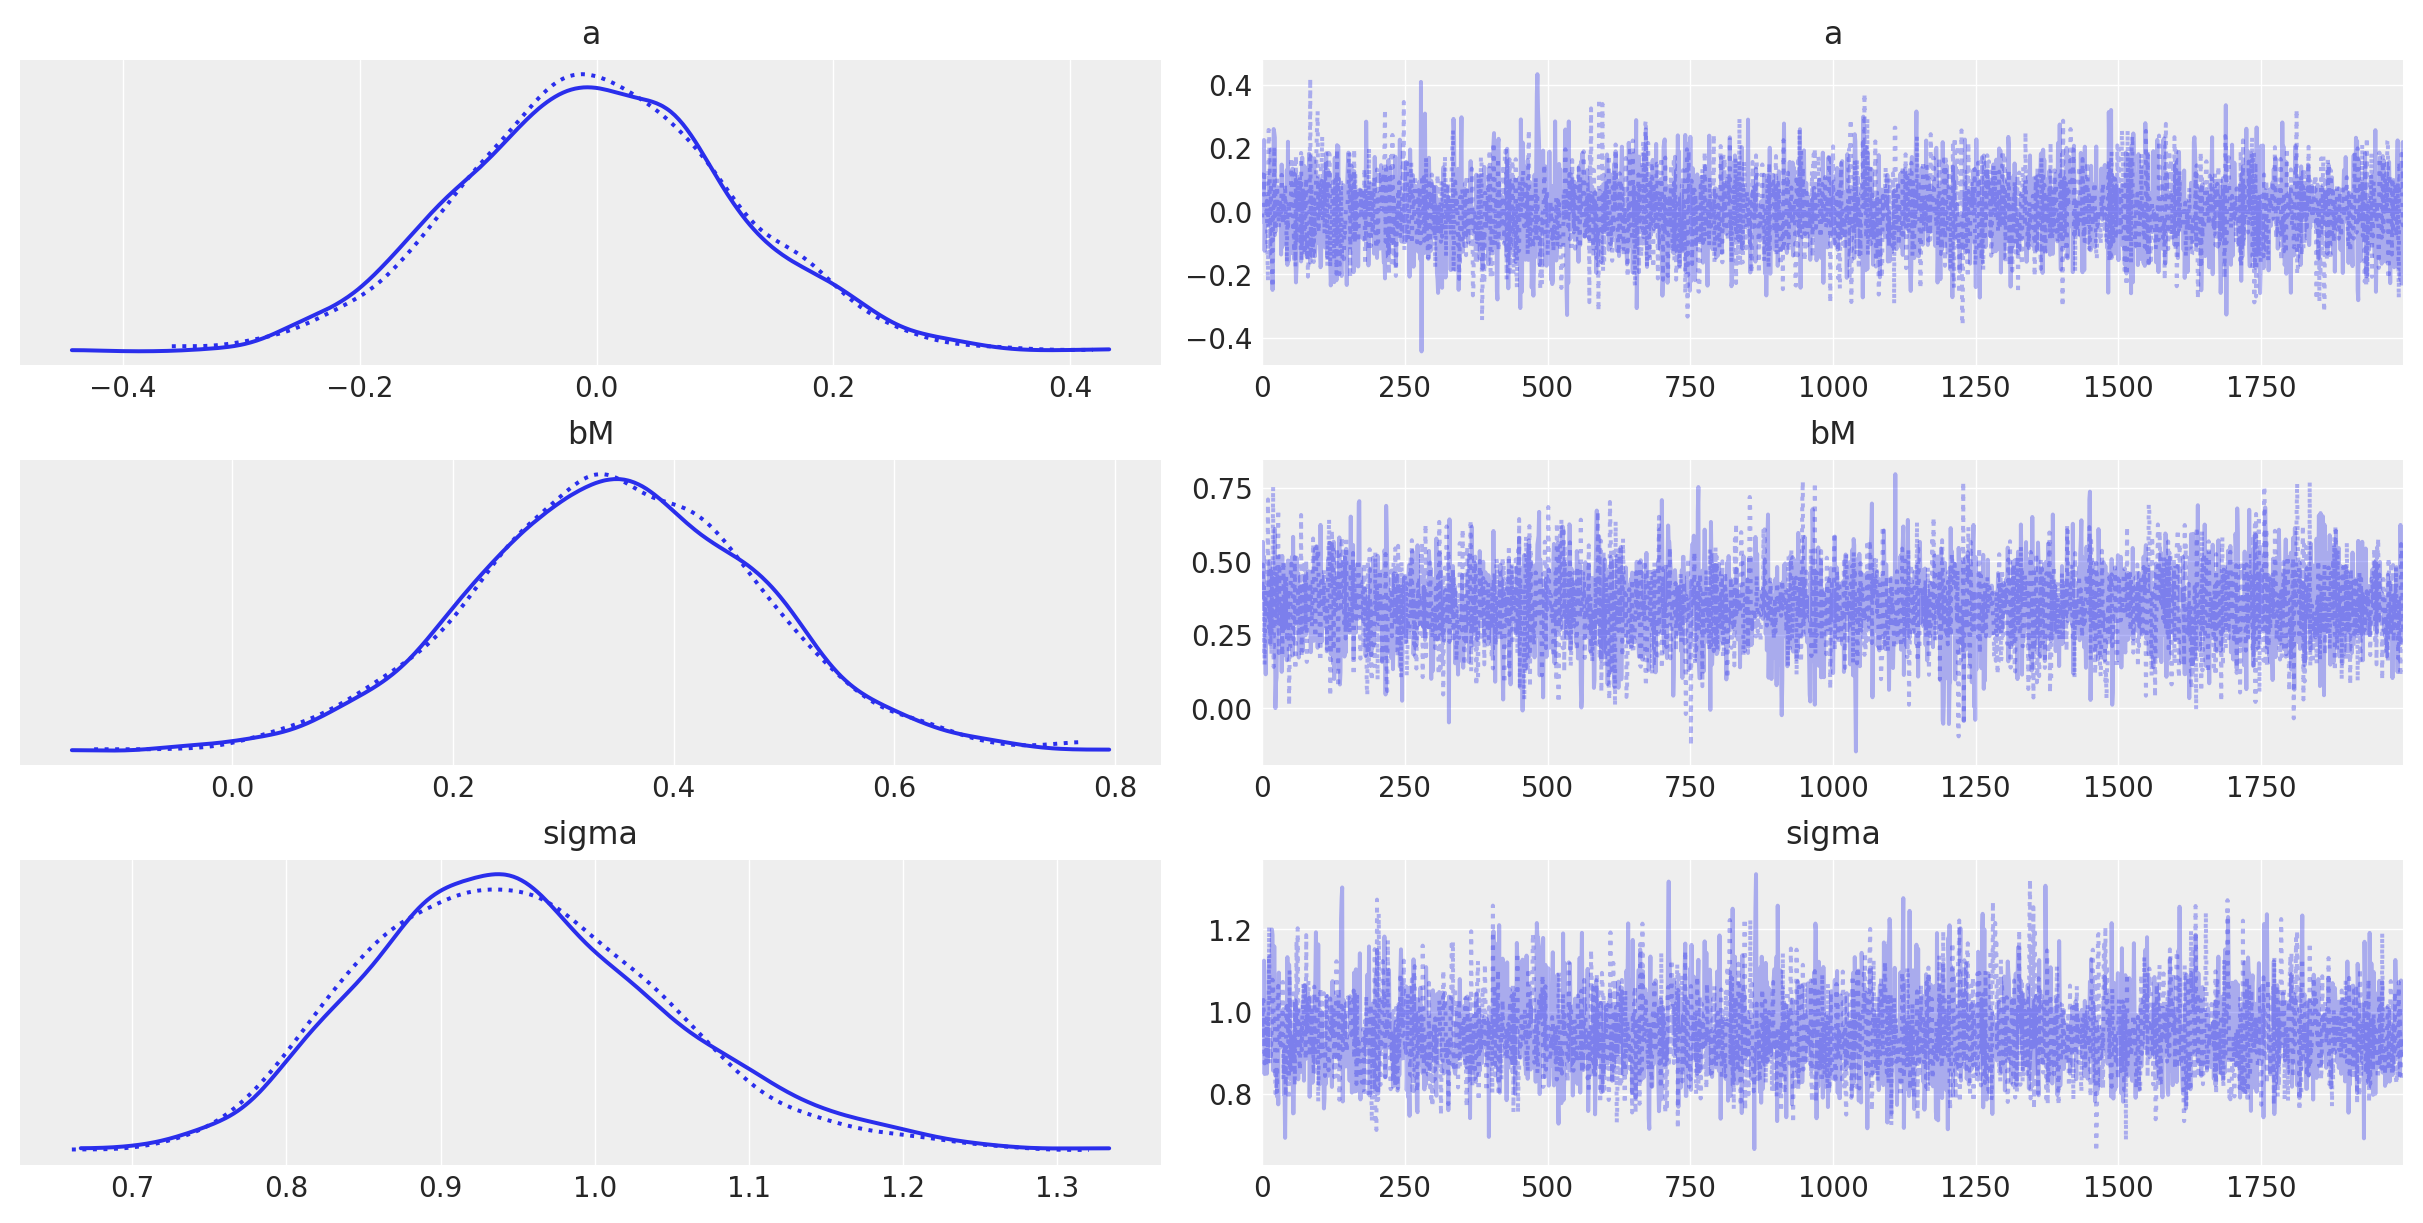

In [55]:
az.plot_trace(idata_1);

### 目的変数の期待値の信用区間
* 信用区間 (credible interval) については、例えば下記のWebページを参照のこと。
 * https://statswithr.github.io/book/introduction-to-bayesian-regression.html

* 線形回帰によるモデリングを表す式：
$y_i = a + b x_i + \epsilon_i$
 * $i$は観測データのインデックス
* 説明変数の値が$x_i$のときの目的変数の期待値：
$\mu_i \equiv E[y | x_i] = E[a + b x_i + \epsilon] = a + b x_i$
* 事後分布からのサンプル$(a^{(s)}, b^{(s)})$を使って求めた、目的変数の期待値：
$\mu_i^{(s)} = a^{(s)} + b^{(s)} x_i$

* 50州の標準化された婚姻率それぞれについて、サンプル毎に回帰式を計算する。

In [56]:
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
)
posterior_mu.shape

(4000, 50)

* 上の計算により、標準化された婚姻率の様々な値に対して、離婚率の期待値がどのように散らばっているかが求められている。
* この結果を使って、標準化された婚姻率の様々な値に対して、対応する離婚率の期待値の、平均とHPDIを求める。

In [59]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)

* 下のヘルパ関数を使って、目的変数の期待値の90%信用区間を描画する。
* 90%信用区間は、90% highest posterior density interval (HPDI)として求めている。
 * https://num.pyro.ai/en/stable/diagnostics.html#hpdi
 * 切片や係数のHPDIを求めて、回帰式に当てはめればよい。

In [60]:
def plot_regression(x, y_mean, y_hpdi):
  # Sort values for plotting by x axis
  idx = jnp.argsort(x)
  marriage = x[idx]
  mean = y_mean[idx]
  hpdi = y_hpdi[:, idx]
  divorce = dset.DivorceScaled.values[idx]

  # Plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
  ax.plot(marriage, mean)
  ax.plot(marriage, divorce, "o")
  ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
  return ax

* そして、ヘルパ関数を呼び出し、可視化する。

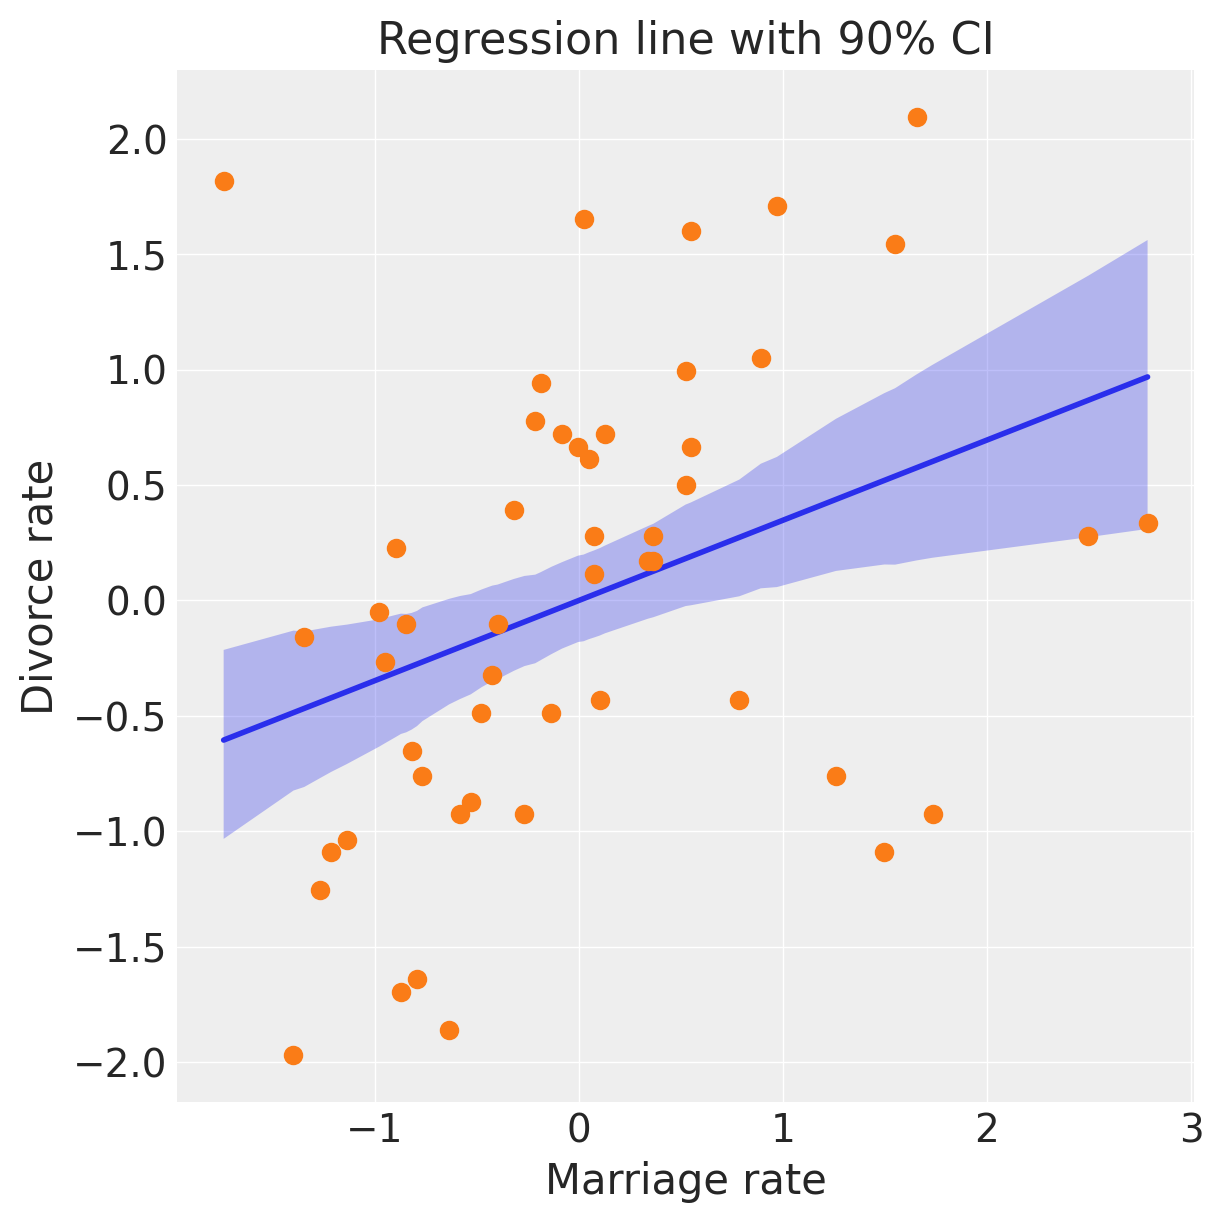

In [61]:
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI",
);

### 目的変数の予測値の信用区間

#### 予測分布とは
* ベイズ的モデリングで、事後分布を求めてどうするのか・・・という話を前回した。
* 事後分布に関して、$\theta$の関数$f(\theta)$の期待値を計算することが、しばしばある。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta$$
 * 例： $f(\theta)$として、データのモデリングに使っている尤度関数$p(x|\theta)$を持ってくると、上の式は予測分布$p(x|X)$を表す。
$$ E_{p(\theta|X)}[p(x|\theta)] = \int p(x|\theta) p(\theta|X) d\theta = p(x|X)$$


#### 予測分布のモンテカルロ近似
* 期待値$E_{p(\theta|X)}[f(\theta)]$のこの計算を、以下の平均値で近似することを、モンテカルロ近似と呼ぶ。
 * $\{ \theta_s \}$は、事後分布$p(\theta|X)$からdrawした$S$個のサンプルを表す。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta \approx \frac{1}{S} \sum_{s=1}^S f(\theta_s) $$

* NumPyroでは、`Predictive`という仕組みを使うと、予測分布からのサンプリングができる。

In [62]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1) # ここで予測分布を作っている
predictions_1 = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]

* `predictions`の形状は、[サンプルの数, 州の数]となっている。

In [63]:
predictions_1.shape

(4000, 50)

* 各州について予測された離婚率の平均を見てみる。

In [66]:
mean_pred = jnp.mean(predictions_1, axis=0)

df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,0.008899
1,Alaska,0.533071
2,Arizona,0.007019
3,Arkansas,0.567212
4,California,-0.080510


* 各州について予測された離婚率の90%信用区間を可視化する。

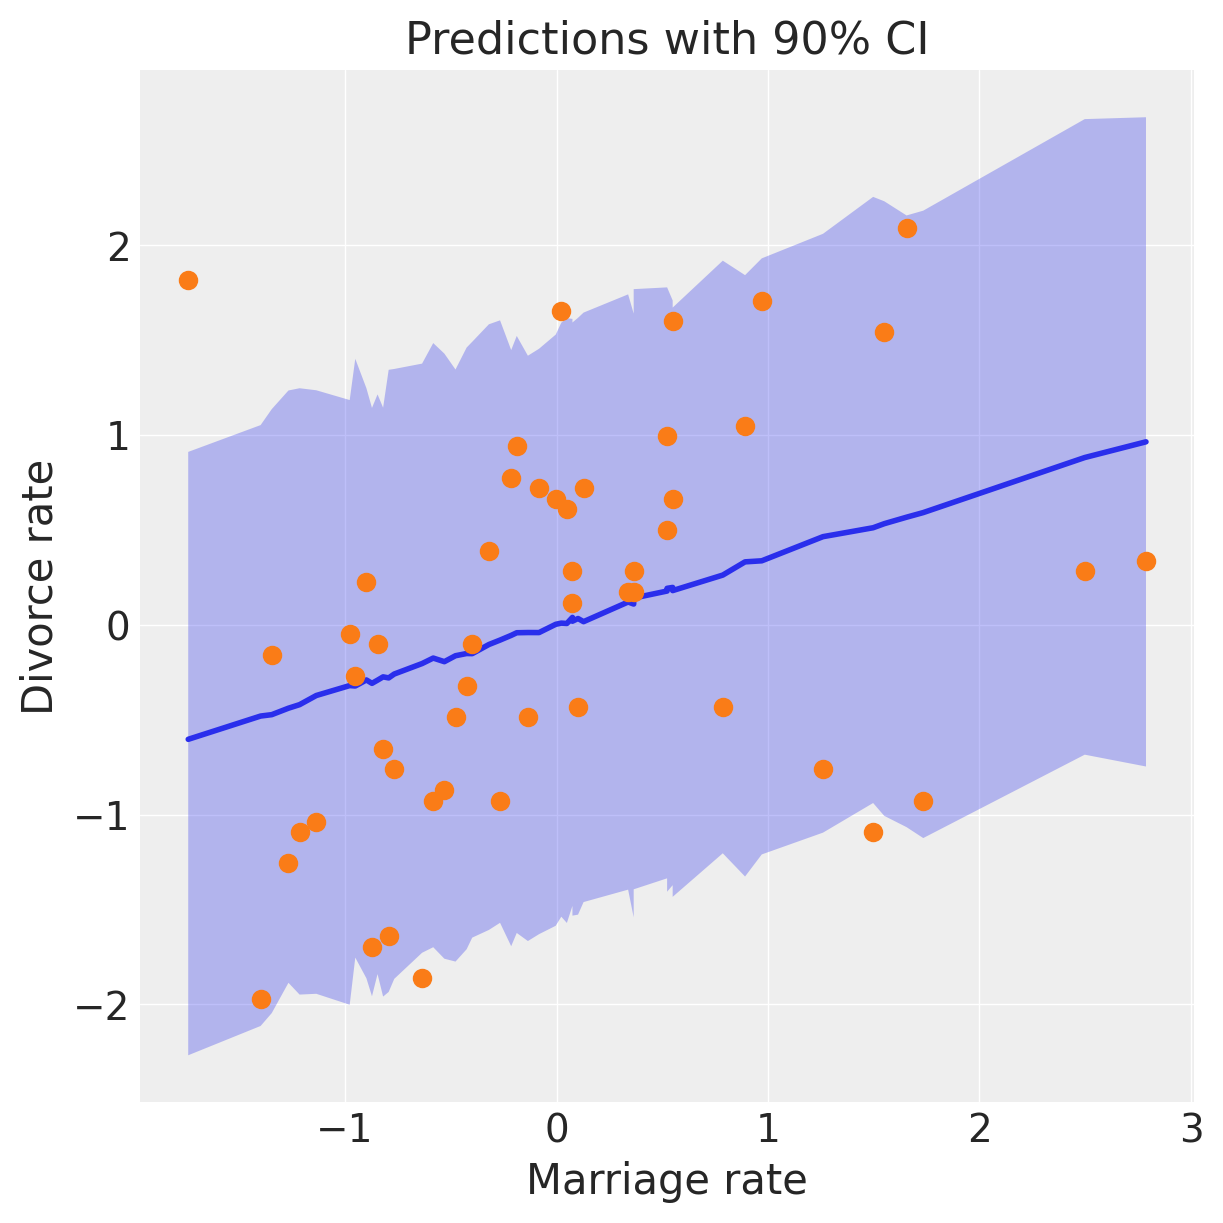

In [67]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

## Hamiltonian Monte Carlo (HMC) の概説
* ここでは直感的な説明をするにとどめる。
* Stanのマニュアルを参考にした。
 * https://mc-stan.org/docs/reference-manual/hamiltonian-monte-carlo.html
* その他の参考資料
 * https://ryokamoi.github.io/blog/tech/2018/12/09/hmc

### 補助変数
* 密度関数$p(\theta)$からのサンプリングを実現したいとする。
 * $p(\theta)$については、規格化定数は不明でも構わない。
* HMCでは、補助変数$\rho$を追加し、同時分布$p(\rho, \theta) = p(\rho|\theta)p(\theta)$からのサンプリングをおこなう。
* 多くの場合（Stanでも）、$\rho$の値が従う分布は、$\theta$に依存しない多変量正規分布だと仮定する。
$$\rho \sim \text{MultiNormal}(0, M)$$
 * $M$は対角成分しか持たないらしい（Stanのマニュアル参照）。

### leapfrogアルゴリズム
* $V(\theta) \equiv - \ln p(\theta)$および$H(\rho, \theta) = - \ln p(\rho, \theta)$と定義する。
* leapfrogアルゴリズムでは、以下のように$\theta$を更新することで、サンプルのchainを作る。

1. $\rho$を$\text{MultiNormal}(0,M)$からdraw
2. 以下の一連の更新式を$L$回繰り返し実行する。
$$\begin{align}
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\notag \\
\theta & \leftarrow \theta + \epsilon M^{-1}\rho
\notag \\
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\end{align}$$
 * この結果、$\rho$は$\rho^*$へ、$\theta$は$\theta^*$へ、それぞれ更新されたとする。
3. この$\rho^*, \theta^*$を、確率$\min(1, \exp(H(\rho, \theta) - H(\rho^*, \theta^*)))$で、次のサンプルとして採用する。
 * 採用されなければ、元の$\rho,\theta$をそのまま次でも使う。



### the no-U-turn sampling (NUTS) アルゴリズム
* leapfrogアルゴリズムで、$M$と$\epsilon$と$L$は、適切に調整すべきパラメータである。
* これらのパラメータを自動的に調整するアルゴリズムとしてHoffmanとGelmanにより提案されたのが、no-U-turn sampling (NUTS)。（終）

### divergence
* leapfrogアルゴリズムは、$\frac{\partial V}{\partial \theta}$を使っている。
* 雰囲気を言うと、これは、本当なら$p(\theta)$の地形に沿って滑らかに動きたいところを、一階の微分を使って近似的に動いている。
* 近似であるため、本当ならそう動きたいという軌道から、外れてしまうこともある。
* この外れ方が非常に大きくなってしまうことを、divergenceと呼ぶ。
* divergenceが大きいと、得られたサンプルchainが所望の密度関数からのサンプルchainとみなせない。
 * MCMCの診断については、次回、説明する。

## モデル2: 婚姻年齢の中央値による予測

# 課題3
* モデル2について、データ分析を実践してみよう。
* ヒント： 使用する説明変数を置き換えればいいだけ。